In [10]:
from torch import nn
import torch
import numpy as np
from scipy import stats
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


import pdb

#        MIN_PERF = 0.
#        MAX_PERF = 100.
#        TASK_DIFFICULTY_SCALE = 1000.
    
#2. * exp(x) / (exp(x) + 1.) - 1.
#a = 5 / asymptote
#     x = sigmoid(a * t / delta)
#     return (p_max - p_min) * x + p_min


class IdealLearner(nn.Module):
    def __init__(self,nalgos,ntasks):
        super().__init__()
        # initialize weights with random numbers
        self.ntasks=ntasks
        self.nalgos=nalgos
        self.min_perf = 0.
        self.max_perf = 100
        self.asymptote=1
        self.task_difficulty_scale = 1
        self.memory_horizon_scale = 1
        self.task_matrix = nn.Parameter(torch.tensor(np.random.random((self.ntasks,self.ntasks))*2-1,requires_grad=True))
        self.task_difficulity = nn.Parameter(torch.tensor(np.random.random((self.ntasks)),requires_grad=True))
        self.alg_efficiency = nn.Parameter(torch.tensor(np.random.normal(0.5, 0.02, size=nalgos),requires_grad=True))
        self.alg_memory_horizon = nn.Parameter(torch.tensor(np.random.normal(.5,.1,size=nalgos),requires_grad=True))
        self.alg_experience_boost = nn.Parameter(torch.tensor(np.random.normal(0.5, 0.02, size=nalgos),requires_grad=True))

        
       
    def forward(self, lx):
        return self.performance(self.ntasks,self.nalgos,self.task_matrix,lx,self.alg_efficiency,self.alg_memory_horizon,self.alg_experience_boost,self.task_difficulity)



    def performance(self,ntasks,nalgos,task_matrix,lx,algo_efficiency,algo_memory, algo_experience_boost,task_difficulity):
        self.result = torch.tensor(np.zeros((nalgos,ntasks,len(lx)+1)))
        self.sig = torch.tensor(np.zeros((nalgos,ntasks,len(lx)+1)))
        for algo in range(nalgos):
            for ind,task in enumerate(lx):
                for task2 in range(task_matrix.shape[0]):
                    
                    prior_exp = torch.sum(self.result[algo,task2,ind:ind+1])*algo_memory[algo]
                    prior_perf = torch.sum(self.sig[algo,task,ind:ind+1])
                    self.result[algo,task2,ind+1] = prior_exp+ task_matrix[task,task2]*algo_efficiency[algo] + task_matrix[task,task2]*prior_perf*algo_experience_boost[algo]
                    
                    difficulty = task_difficulity[task2]*self.task_difficulty_scale
                    self.sig[algo,task2,ind+1] = (1/(1+(torch.exp(-1*self.result[algo,task2,ind+1]/difficulty)))*2)-1

        return self.sig

    def sigmoid(self,x):
        return 2. * torch.exp(x) / (torch.exp(x) + 1.) - 1.   
        

    def last_seen(self,lx,task,current_index):
        result = 0
        for i in range(current_index-1,0,-1):
            if lx[i] is not task:
                result+=1
            else:
                return result
        return result

    def optimize(self,lx,target,iters=1000):
        optimizer = torch.optim.Adam(self.parameters(),lr=.01)
        self.target = target
        self.lx = lx
        self.losses = []
        for i in range(iters):
            optimizer.zero_grad()
            #target = model.performance(ntasks,nalgos,true_task_association,lx,true_algo_efficiency,true_algo_memory,true_algo_experience_bonus)

            prediction = self(lx)
            self.prediction = prediction
            #pdb.set_trace()
            loss = torch.nn.functional.mse_loss(target,prediction)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                self.task_matrix.clamp_(-1,1)
                self.task_difficulity.clamp_min_(0)
                self.alg_efficiency.clamp_min_(0)
                self.alg_memory_horizon.clamp_(0,1)
                self.alg_experience_boost.clamp_min_(0)
                self.result.clamp_min_(0)
            
            self.losses.append(loss.detach().numpy())
        plt.plot(self.losses)

    def print_algo_results(self,algo_names=None):
        data = {'algorithm': range(self.nalgos),
                'efficiency':self.alg_efficiency.detach().numpy(),
                'retention': self.alg_memory_horizon.detach().numpy(),
                'expertice': self.alg_experience_boost.detach().numpy()}
        if algo_names is not None:
            data['algorithm'] = algo_names
        df = pd.DataFrame(data).to_csv(index=False)
        print(df)

    def print_task_transfer(self):
        print(pd.DataFrame(self.task_matrix.detach().numpy()).to_csv(index=False,header=False))






    
        
    



final model MSE loss 6.082978672992873e-06
task transfer matrix
 [[ 1.          0.43037873  0.20552675  0.08976637 -0.1526904 ]
 [ 0.29178823  1.          0.783546    0.92732552 -0.23311696]
 [ 0.58345008  0.05778984  1.          0.85119328 -0.85792788]
 [-0.8257414  -0.95956321  0.66523969  1.          0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835  1.        ]]

0.8537749306176959,0.35489793217784826,0.09219423337339525,0.040004823090492185,-0.1019952231588368
0.24801656538651373,0.7996512924107856,0.3666663702948287,0.4474578286650723,-0.1631107128070891
0.49598602232938127,0.044519141569944826,0.4621413411032506,0.40571727450850775,-0.5968029774036582
-0.732679656666019,-0.8039830216993327,0.30943688796211705,0.4811365529076981,0.5384975861166673
0.8991421069014842,0.3250537339000885,-0.9728567287757803,0.24569219109333895,0.3473192616715788

task transfer mse 0.11740062058175652

task difficulty 0.04302912952445247 [0.63992102 0.14335329 0.94466892 0.52184832 0.4146

IndexError: index 5 is out of bounds for dimension 1 with size 5

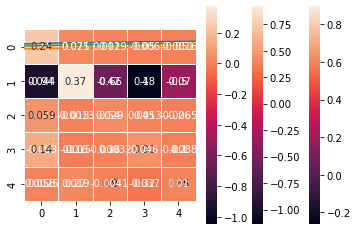

In [12]:

n_tasks=5
n_algos=3


np.random.seed(0)
torch.manual_seed(0)
ntasks = n_tasks
true_task_association = ((np.random.random((ntasks,ntasks))*2)-1)
true_task_difficulity = np.random.random(ntasks)
for i in range(ntasks):
    true_task_association[i,i] = 1

nalgos = n_algos
true_algo_efficiency = np.random.random(nalgos)
true_algo_memory = np.random.random(nalgos)
true_algo_experience_bonus = np.random.random(nalgos)
    
lx = []
slices = list()
order = np.random.randint(low=0, high=ntasks+1, size=9)
for i in order:
    before = len(lx)
    lx.extend([i])
    after = len(lx)
    slices.append([0,before,after,i])
#lx = [0,1,2,3,4,5,0,1,2,3,4,5 ]

model = IdealLearner(nalgos,ntasks)
target = model.performance(ntasks,nalgos,true_task_association,lx,true_algo_efficiency,true_algo_memory,true_algo_experience_bonus,true_task_difficulity)
#target = np_arr
model.optimize(lx,target,iters=1000)

print('final model MSE loss', model.losses[-1])
print('task transfer matrix\n',true_task_association,)
print()
model.print_task_transfer()
transfer_difference = true_task_association - model.task_matrix.detach().numpy()
plt.imshow(transfer_difference, cmap='hot', interpolation='nearest')
ax = sns.heatmap(transfer_difference, linewidth=0.5,annot=True)
matrix_mse = (transfer_difference**2).mean(axis=None)
print('task transfer mse',matrix_mse)
print()
task_mse = ((true_task_difficulity - model.task_difficulity.detach().numpy())**2).mean(axis=None)
print('task difficulty',task_mse,true_task_difficulity,model.task_difficulity.detach().numpy())

transfer_mse = ((true_algo_efficiency - model.alg_efficiency.detach().numpy())**2).mean(axis=None)
print('algo transfer efficiency',transfer_mse,true_algo_efficiency,model.alg_efficiency.detach().numpy())

memory_mse = ((true_algo_memory - model.alg_memory_horizon.detach().numpy())**2).mean(axis=None)
print('algo memory horizon',memory_mse,true_algo_memory,model.alg_memory_horizon.detach().numpy())

expertice_mse = ((true_algo_experience_bonus - model.alg_experience_boost.detach().numpy())**2).mean(axis=None)
print('algo experience bonus',expertice_mse,true_algo_experience_bonus,model.alg_experience_boost.detach().numpy())


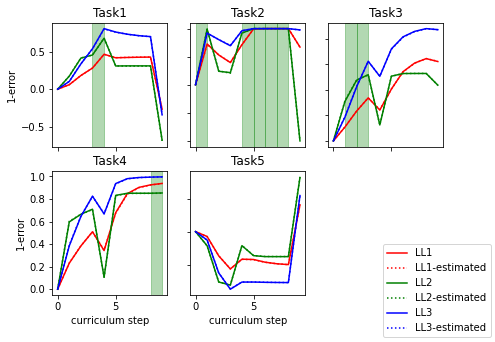

In [8]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ['Task1',"Task2","Task3","Task4","Task5"]
algos = ['LL1',"LL2","LL3"]
colors =['r','g','b']
prediction = model.prediction.detach().numpy()
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],colors[algo],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],colors[algo]+":",label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1-error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# MNIST Incremental Domain Analysis

final model MSE loss 0.0189484139266888
0.9995230997427083,-0.011698127949790025,0.02663833659218764,0.04814586920486076,-0.13296114307309434
-0.3765359296194338,0.8802778069273374,0.07623272346898485,0.07289172978531862,0.11557984407327428
-0.17727780716082872,0.3775728404140322,0.9873279283967171,-0.08893248661567431,-0.3548824962660274
0.26771757454507306,-0.22269080806818306,-0.6606248943674731,1.0,0.40863622906707303
-0.16295431293641757,-0.01656533216584569,-0.19495683428344338,-0.1683863794464329,0.7507692186679623


task difficulty [0.10516981 0.11251319 0.1085464  0.08332458 0.25238895]

algorithm,efficiency,retention,expertice
GEM_1100,0.7929818136143681,0.9833725784972329,0.3090071293683858
GEM_4400,0.8849199600305275,1.0,0.12429185849790342
EWC_online_mnist,0.9591528078406902,0.4373923496811055,0.5790258093027028
EWC_mnist,0.8621598768375421,0.4311102486270944,0.5655759903538617
MAS,0.319398190203077,0.9093751298164919,0.09464558315553184
L2,0.7354484565187273,0.52816068355

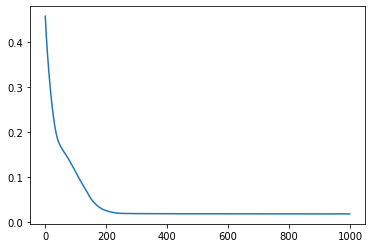

In [9]:
import yaml
from collections import defaultdict
import collections

files = [("GEM_1100",0.5),("GEM_4400",0.5),("EWC_online_mnist",700.0),("EWC_mnist",100.0),
("MAS",10000.0),("L2",0.5),("Naive_Rehearsal_1100",0.0),("Naive_Rehearsal_4400",0.0),("NormalNN",0.0),("SI",3000.0)]

np.random.seed(0)
torch.manual_seed(0)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=5
nalgos=len(files)
timepoints=5
minv = 50
maxv = 100 
lx = [0,1,2,3,4] # curriculum 
target = torch.from_numpy(np.zeros((nalgos,ntasks,len(lx)+1)))#2 algos,5 tasks, 6 timpoints

for algo in range(nalgos):
    with open('../data/mnist/'+files[algo][0]+'.yaml','r') as fname:
        data = yaml.load(fname, Loader=yaml.FullLoader)
        for task in range(ntasks):
            for t in range(len(lx)+1):
                val = data[files[algo][0]][files[algo][1]][0]['acc_table']['val'][str(t)][str(task+1)]
                normv = (val-minv)/(maxv-minv)
                target[algo,task,t] = normv

model2 = IdealLearner(nalgos,ntasks)
model2.optimize(lx,target,iters=1000)
print('final model MSE loss', model2.losses[-1])
model2.print_task_transfer()
prediction = model2.prediction.detach().numpy()
print()
print('task difficulty',model2.task_difficulity.detach().numpy())
print()
#print('algo transfer efficiency',model2.alg_efficiency.detach().numpy())
#print('algo memory horizon',model2.alg_memory_horizon.detach().numpy())
#print('algo experience bonus',model2.alg_experience_boost.detach().numpy())
algos = [files[algo][0] for algo in range(nalgos)]
model2.print_algo_results(algo_names=algos)


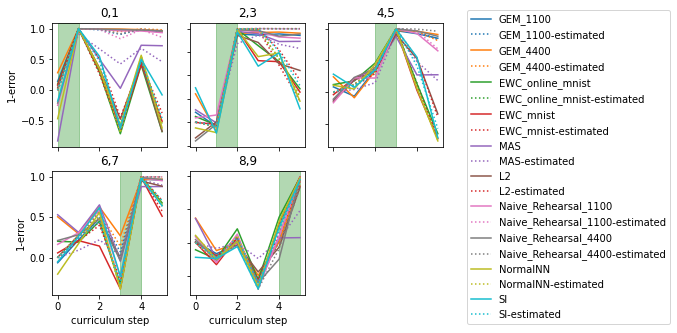

In [5]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ["0,1","2,3","4,5","6,7","8,9"]
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive','tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1-error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.36, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## CIFAR100 Incremental Task Analysis

final model MSE loss 0.0025126642154122414
0.9632839916452619,0.15054304917488653,0.06251034675709498,0.066784508994683,0.03813464942411216
-0.5580562361460196,0.9066981087202334,0.005452328425664545,-0.009509925189374723,0.005803399381070345
7.410967688092234e-05,-0.13157606183029844,1.0000947497618047,0.007855809544492087,0.003546350694904179
0.0027693434493929773,0.0006294014633418663,-0.1186711800368376,1.0003862392954899,0.005738879162933761
0.007671317291683034,0.08918989437992993,0.09799020847724697,-0.08646162107346649,1.0001024340044105


task difficulty [0.02802318 0.27460873 0.27849323 0.29975529 0.25493745]

algorithm,efficiency,retention,expertice
EWC_online,0.34518226864208806,0.9965257815041917,2.106247666051822
EWC,0.6013300161621421,0.6149520098111906,-0.0004950299896541893
MAS,0.3312764923040479,0.9427235442001827,1.0352475208331913
L2,0.12260831720038984,1.004342123395598,-0.0021142229399518943
Naive_Rehearsal_1400,0.5733096825179889,0.8412743036956272,1.032974728164

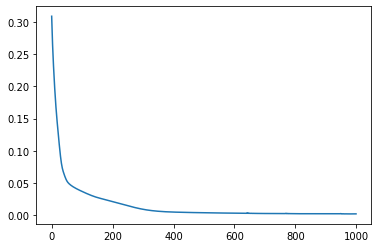

In [6]:
import yaml
from collections import defaultdict
import collections

files = [("EWC_online",3000.0),("EWC",100.0),("MAS",10.0),("L2",1.0),("Naive_Rehearsal_1400",0.0),("Naive_Rehearsal_5600",0.0),("NormalNN",0.0),("SI",2.0)]
np.random.seed(0)
torch.manual_seed(0)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=5
nalgos=len(files)
timepoints=6
minv = 0
maxv = 100 
lx = [0,1,2,3,4]
target = torch.from_numpy(np.zeros((nalgos,ntasks,timepoints)))#2 algos,5 tasks, 6 timpoints

for algo in range(nalgos):
    with open('../data/cifar100/'+files[algo][0]+'.yaml','r') as fname:
        data = yaml.load(fname, Loader=yaml.FullLoader)
        for task in range(ntasks):
            for t in range(timepoints):
                val = data[files[algo][0]][files[algo][1]][0]['acc_table']['val'][str(t)][str(task+1)]
                normv = (val-minv)/(maxv-minv)
                target[algo,task,t] = normv
#print(target)
model3 = IdealLearner(nalgos,ntasks)
model3.optimize(lx,target,iters=1000)
print('final model MSE loss', model3.losses[-1])
model3.print_task_transfer()
prediction = model3.prediction.detach().numpy()
print()
print('task difficulty',model3.task_difficulity.detach().numpy())
print()
algos=[files[algo][0] for algo in range(nalgos)]
model3.print_algo_results(algo_names=algos)

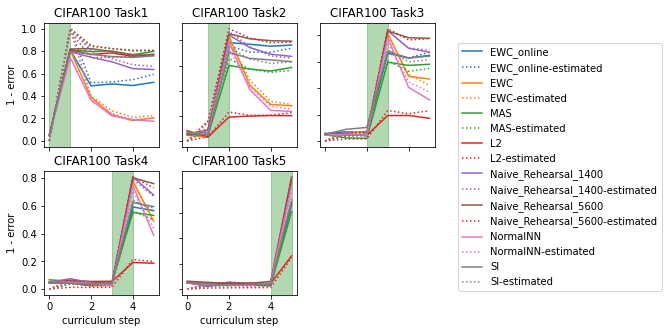

In [7]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ["CIFAR100 Task1","CIFAR100 Task2","CIFAR100 Task3","CIFAR100 Task4","CIFAR100 Task5"]
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive','tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1 - error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.36, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## CRL Analysis

    step  clear   pnc  oewc  ewc  impala
0      0      0     0     0    0       0
1     50   2350   850   800  950     900
2    100   1000    50   100  500     100
3    150   1200   250   150  500     100
4    200   1050   300   150  500     100
5    250   1000    50   100  500     100
6    300    900    50   100  500     100
7    350   2800  1000   750  500    1200
8    400   2500   250   200  500     200
9    450   2400   200   200  500     250
10   500   2300   250   200  500     200
11   550   1900   150   200  500     150
12   600   1950   150   200  500     150
    step  clear   pnc  oewc   ewc  impala
0      0      0     0     0     0       0
1     50    500   500     0  1000       0
2    100   8750  6500  6500  2000    7000
3    150   6500  1000  2000  2250    1850
4    200   6750  1000  1850  2250       0
5    250   7000   500   500  1750    1800
6    300   6500   500  1250  1750    1000
7    350   6500  1000  1750  2000    1500
8    400   9500  6500  6500  2000    8000
9    4

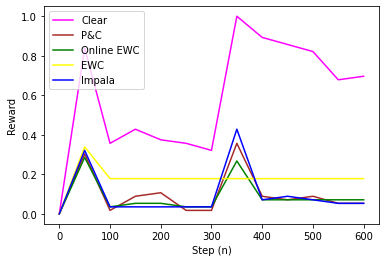

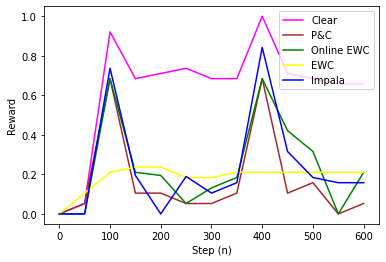

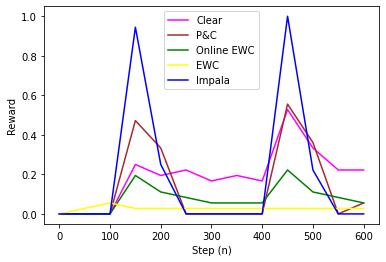

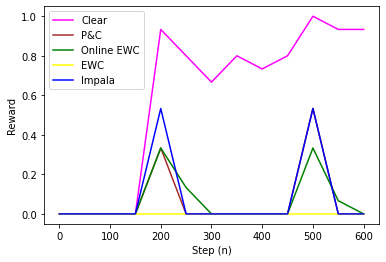

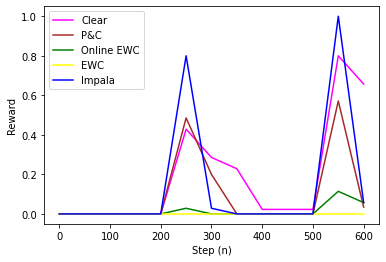

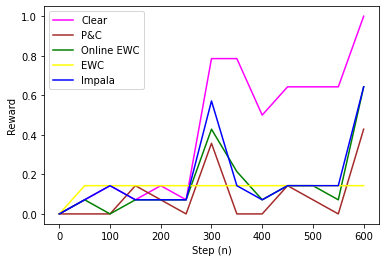

torch.Size([5, 6, 13])


In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 

n_tasks = 6
n_steps = 13
n_algos = 5
np_arr = np.zeros([n_algos,n_tasks,n_steps])
for i in range(6):
    stri = 'df' + str(i)
    readfile = '../data/atari/game' + str(i) + '.csv'
    df = pd.read_csv(readfile)
    exec(f"{stri} = df")
    M = df.iloc[:,1:].max().max()

    plt.figure(i) 
    plt.plot(df["step"],df["clear"]/M,color = 'magenta',label = "Clear")
    plt.plot(df["step"],df["pnc"]/M,color = 'brown',label = "P&C")
    plt.plot(df["step"],df["oewc"]/M,color = 'green',label = "Online EWC")
    plt.plot(df["step"],df["ewc"]/M,color = 'yellow',label = "EWC")
    plt.plot(df["step"],df["impala"]/M,color = 'blue',label = "Impala")
    plt.xlabel('Step (n)')
    plt.ylabel('Reward')
    plt.legend()

    dfnp = df.to_numpy()[:,1:]
    print(df)
    np_arr[:,i,:] = dfnp.transpose() / M 
    #fname = '.\data\crl\images\game_'+str(i)+'.png'
    #plt.savefig(fname)

plt.show()
targ = torch.tensor(np_arr.astype(float))
print(targ.shape)


final model MSE loss 0.007467192736243876
1.0003662144931997,0.15066543926769832,-0.12746311927666618,0.008457942325976481,-0.1612638735042752,0.025515714526018862
-0.09258925224160763,1.000458485218518,0.20663674990808178,-0.018039907858593933,-0.052187352169866044,0.018781956192321703
0.04129109158420781,-0.14801646178811748,1.0014662217629895,0.012027583744630772,0.03782556684478461,0.07902766383545098
0.1260651871834325,0.04914962259277108,-0.3308979059166572,0.9989468864053617,0.10433637972285904,0.11322995090447985
0.006409266138730324,0.07387284763073142,-0.16439400356754755,-0.12288881489454687,0.9980232786735256,-0.025673487226641818
-0.02608224051890151,0.03551267491485908,-0.001098234022014844,-0.00546086617361499,-0.38036115876225685,0.9997945700988062


task difficulty [0.08643037 0.08258886 0.15037566 0.06806343 0.09727255 0.0839263 ]

algorithm,efficiency,retention,expertice
Clear,0.1238402669232763,0.9013524641539383,0.033355620980563654
P&C,0.059575886872329155,0.3501

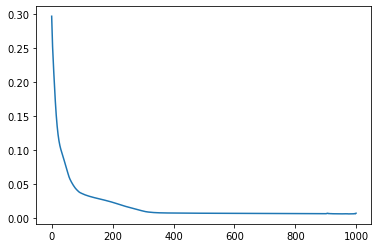

In [9]:

np.random.seed(1)
torch.manual_seed(1)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=6
nalgos=5
timepoints=13
minv = 10
maxv = 200 
lx = [0,1,2,3,4,5,0,1,2,3,4,5] # curriculum 
target = targ

model4 = IdealLearner(nalgos,ntasks)
model4.optimize(lx,target,iters=1000)
print()
print('final model MSE loss', model4.losses[-1])
model4.print_task_transfer()
prediction = model4.prediction.detach().numpy()
print()
print('task difficulty',model4.task_difficulity.detach().numpy())
print()
model4.print_algo_results(algo_names=['Clear','P&C','Online EWC', 'EWC','Impala'])

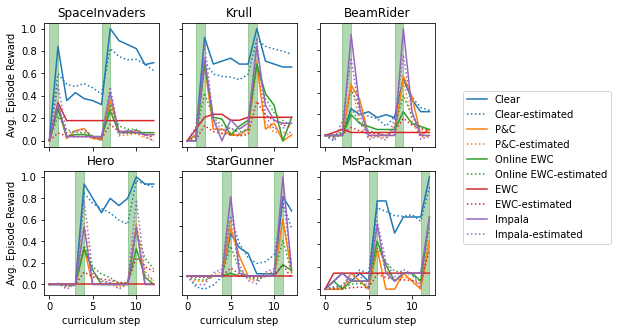

In [10]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
tasks = ["SpaceInvaders","Krull","BeamRider","Hero",'StarGunner',"MsPackman"]
algos = ['Clear','P&C','Online EWC', 'EWC','Impala']
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive','tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)
            


#axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='Avg. Episode Reward')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels,  loc="center right", bbox_to_anchor=(1.26, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

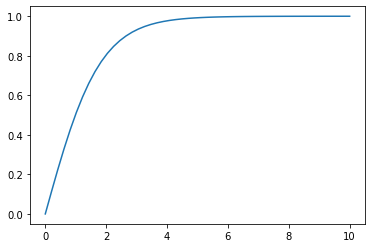

In [3]:
x = np.linspace(0,10)
y = (1/(1+(np.exp(-1*x/.90)))*2)-1
plt.plot(x,y)
plt.show()